In [7]:
from lungmask import lungmask
from lungmask import resunet
from CirData.Base import CirData
from py_jotools import mut, augmentation, slurm
import SimpleITK as sitk
import numpy as np
import scipy
from scipy.ndimage import rotate, gaussian_filter
import torch
from marp.MRC import MRContext, HDDCacher
import matplotlib.pyplot as plt
import edt
import random
from functools import partial
import imageio
import functools
import pydicom
import data_prep
import numpy as np
import os

In [3]:
cd = data_prep.cd
lr_events = cd.get_events_for_proj('lung_b3_3mm')
np.random.seed(seed=1039717)
np.random.shuffle(lr_events)
print(lr_events[0])
lr_events_only = [x[0] for x in lr_events]
hr_events = cd.get_events_for_proj('lung_b6_1mm')
np.random.shuffle(hr_events)
print(hr_events[0])
hr_events_only = [x[0] for x in hr_events]
domains = {
    'default': lr_events_only + hr_events_only,
    'lr': lr_events_only,
    'hr': hr_events_only
}

['D4EDA423_20040121_dicom_38786' 'D4EDA423932D400E97E720D7E06C3CA7'
 datetime.datetime(2004, 1, 21, 0, 0) 'dicom']
['075DW4AL_20150424_dicom_259874' '075DW4ALL'
 datetime.datetime(2015, 4, 24, 0, 0) 'dicom']


In [4]:
def centerslice(vol, msk):
    import SimpleITK as sitk
    import numpy as np
    vol = sitk.GetArrayFromImage(vol)
    msk = msk>0
    centersli = int(np.round(np.mean(np.where(np.sum(np.sum(msk,axis=1),axis=1)))))
    centersl_msk = msk[centersli, ...]
    centersl_img = vol[centersli, ...]
    return centersl_img, centersl_msk

lungseg = partial(lungmask.apply, model=lungmask.get_model('unet','LTRCLobes'))

def centerslice_cat(centersls, difficulty='MH', event_id = None):
    (centersl_img, centersl_msk) = centersls

    cat = np.load('catpic.npy')
    
    if difficulty == 'E':
        cat_rot = mut.rescale(cat,1.3,order=1, anti_aliasing=True)
    elif difficulty == 'M':
        cat_rs = mut.rescale(cat,random.uniform(0.9,1.3),order=1, anti_aliasing=True)
        cat_rot = rotate(cat_rs, random.uniform(-45,45), order=1)
        cat_rot = mut.crop_to_mask(cat_rot,msk=cat_rot>0)
    elif difficulty == 'MH':
        print(event_id)
        cat_rs = mut.rescale(cat,random.uniform(0.6,1.0),order=1, anti_aliasing=True)
        cat_rot = rotate(cat_rs, random.uniform(-45,45), order=1)
        dich = cd.get_dicom_header_event(event_id)
        if dich[0][0]['SliceThickness'] >=2.99:
            cat_rot = gaussian_filter(cat_rot,1.8)
        cat_rot = mut.crop_to_mask(cat_rot,msk=cat_rot>0)
    elif difficulty == 'HH':
        print(event_id)
        cat_rs = mut.rescale(cat,random.uniform(0.3,0.8),order=1, anti_aliasing=True)
        cat_rot = rotate(cat_rs, random.uniform(0,359), order=1)
        dich = cd.get_dicom_header_event(event_id)
        if dich[0][0]['SliceThickness'] >=2.99:
            cat_rot = gaussian_filter(cat_rot,1.3)
        cat_rot = mut.crop_to_mask(cat_rot,msk=cat_rot>0)
    else:
        cat_rs = mut.rescale(cat,random.uniform(0.6,1),order=1, anti_aliasing=True)
        cat_rot = rotate(cat_rs, random.uniform(0,359), order=1)
        cat_rot = mut.crop_to_mask(cat_rot,msk=cat_rot>0)
    cat_size = cat_rot.shape
    cat_rot_dist = np.sqrt(cat_rot.shape[0]**2+cat_rot.shape[1]**2)

    sl_dt = edt.edt(centersl_msk)
    sl_dt = sl_dt>(cat_rot_dist/2)
    rc = np.asarray(np.where(sl_dt))[:,np.random.randint(np.sum(sl_dt.astype(int)))]

    catcut = centersl_img[rc[0]-np.floor(cat_size[0]/2).astype(int):rc[0]+np.ceil(cat_size[0]/2).astype(int),
                          rc[1]-np.floor(cat_size[1]/2).astype(int):rc[1]+np.ceil(cat_size[1]/2).astype(int)]
    
    if difficulty == 'E':
        catcut_withcat = catcut+(cat_rot/255)*700
    elif difficulty == 'M':
        catcut_withcat = catcut+(cat_rot/255)*random.uniform(500,700)
    elif difficulty == 'MH':
        catcut_withcat = catcut+(cat_rot/255)*random.uniform(500,700)
    elif difficulty == 'HH':
        catcut_withcat = catcut+(cat_rot/255)*random.uniform(200,400)
    else:
        catcut_withcat = catcut+(cat_rot/255)*random.uniform(300,500)


    centersl_img_withcat = centersl_img.copy()
    centersl_img_withcat[rc[0]-np.floor(cat_size[0]/2).astype(int):rc[0]+np.ceil(cat_size[0]/2).astype(int),
                          rc[1]-np.floor(cat_size[1]/2).astype(int):rc[1]+np.ceil(cat_size[1]/2).astype(int)] = catcut_withcat
    return centersl_img_withcat

def centerslice_ball(centersls, difficulty='MH', event_id = None):
    (centersl_img, centersl_msk) = centersls

    cat = mut.binary_kernel_circ(41).astype(float)*255
    
    if difficulty == 'E':
        cat_rot = mut.rescale(cat,1.3,order=1, anti_aliasing=True)
    elif difficulty == 'M':
        cat_rs = mut.rescale(cat,random.uniform(0.9,1.3),order=1, anti_aliasing=True)
        cat_rot = cat_rs
        cat_rot = mut.crop_to_mask(cat_rot,msk=cat_rot>0)
    elif difficulty == 'MH':
        print(event_id)
        cat_rs = mut.rescale(cat,random.uniform(0.6,1.0),order=1, anti_aliasing=True)
        cat_rot = cat_rs
        dich = cd.get_dicom_header_event(event_id)
        if dich[0][0]['SliceThickness'] >=2.99:
            cat_rot = gaussian_filter(cat_rot,1.8)
        cat_rot = mut.crop_to_mask(cat_rot,msk=cat_rot>0)
    elif difficulty == 'HB':
        print(event_id)
        cat_rs = mut.rescale(cat,random.uniform(0.6,1.0),order=1, anti_aliasing=True)
        cat_rot = cat_rs
        dich = cd.get_dicom_header_event(event_id)
        if dich[0][0]['SliceThickness'] >=2.99:
            cat_rot = gaussian_filter(cat_rot,1.3)
        cat_rot = mut.crop_to_mask(cat_rot,msk=cat_rot>0)
    else:
        cat_rs = mut.rescale(cat,random.uniform(0.6,1),order=1, anti_aliasing=True)
        cat_rot = rotate(cat_rs, random.uniform(0,359), order=1)
        cat_rot = mut.crop_to_mask(cat_rot,msk=cat_rot>0)
        
    cat_size = cat_rot.shape
    cat_rot_dist = np.sqrt(cat_rot.shape[0]**2+cat_rot.shape[1]**2)

    sl_dt = edt.edt(centersl_msk)
    sl_dt = sl_dt>(cat_rot_dist/2)
    rc = np.asarray(np.where(sl_dt))[:,np.random.randint(np.sum(sl_dt.astype(int)))]

    catcut = centersl_img[rc[0]-np.floor(cat_size[0]/2).astype(int):rc[0]+np.ceil(cat_size[0]/2).astype(int),
                          rc[1]-np.floor(cat_size[1]/2).astype(int):rc[1]+np.ceil(cat_size[1]/2).astype(int)]
    
    if difficulty == 'E':
        catcut_withcat = catcut+(cat_rot/255)*700
    elif difficulty == 'M':
        catcut_withcat = catcut+(cat_rot/255)*random.uniform(500,700)
    elif difficulty == 'MH':
        catcut_withcat = catcut+(cat_rot/255)*random.uniform(500,700)
    else:
        catcut_withcat = catcut+(cat_rot/255)*random.uniform(400,600)


    centersl_img_withcat = centersl_img.copy()
    centersl_img_withcat[rc[0]-np.floor(cat_size[0]/2).astype(int):rc[0]+np.ceil(cat_size[0]/2).astype(int),
                          rc[1]-np.floor(cat_size[1]/2).astype(int):rc[1]+np.ceil(cat_size[1]/2).astype(int)] = catcut_withcat
    return centersl_img_withcat



In [5]:
mr = MRContext(domains)
cacher = HDDCacher('/project/catinous/mr_cache')
nd_load_img = mr.node(tmpcache=False).set_function(data_prep.get_vol, mr.root_node())
nd_lungmask = mr.node(hddcacher=cacher).set_function(lungseg, nd_load_img)
nd_centerslice = mr.node(hddcacher=cacher).set_function(centerslice, nd_load_img, nd_lungmask)
nd_centerslice_cat = mr.node(hddcacher=cacher).set_function(centerslice_cat, nd_centerslice)
nd_centerslice_cat_easy = mr.node(hddcacher=cacher).set_function(centerslice_cat, nd_centerslice, difficulty='E')
nd_centerslice_cat_med = mr.node(hddcacher=cacher).set_function(centerslice_cat, nd_centerslice, difficulty='M')
nd_centerslice_cat_medh = mr.node().set_function(centerslice_cat, nd_centerslice, difficulty='MH', event_id=mr.root_node())
nd_centerslice_ball_medh = mr.node().set_function(centerslice_ball, nd_centerslice, difficulty='MH', event_id=mr.root_node())
nd_centerslice_ball_hard = mr.node().set_function(centerslice_ball, nd_centerslice, difficulty='HB', event_id=mr.root_node())
nd_centerslice_cat_hard = mr.node().set_function(centerslice_cat, nd_centerslice, difficulty='HB', event_id=mr.root_node())
nd_centerslice_cat_hardhard = mr.node().set_function(centerslice_cat, nd_centerslice, difficulty='HH', event_id=mr.root_node())

Compute:  centerslice_cat  Item:  5001 Domain:  default
Reload from persistent:  centerslice  Item:  5001 Domain:  default   9962729508d6ff5d17d93125c95cf0f7b8f5fa99
04628OAL_20150312_dicom_258576


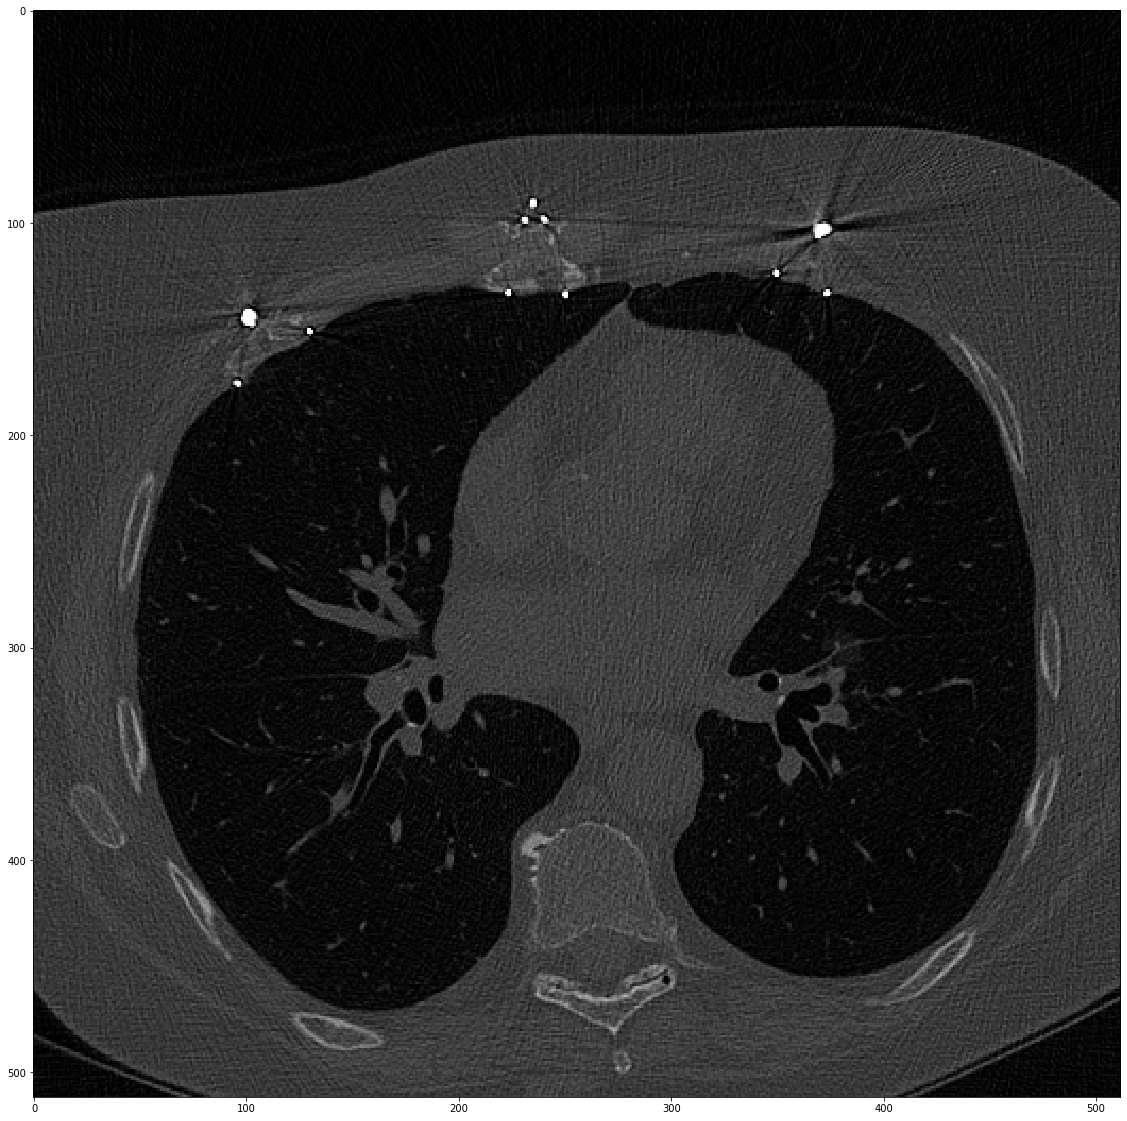

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(nd_centerslice_cat_hardhard.resolve(5001))

In [7]:
mut.mimshow(nd_load_img.resolve(1001),tmsk)

Compute:  get_vol  Item:  1001 Domain:  default
INFO:CirData.Base:Request volume from event: 2E5FB1D1_20130912_dicom_78212 


NameError: name 'tmsk' is not defined

In [ ]:
# to_compute = np.where([not nd_centerslice.is_hdd_cached(i, 'default') for i in range(len(domains['default']))])[0]
# print(len(to_compute))

In [ ]:
# params = {
#     'binary': '/home/cir/jhofmanninger/env/candid/bin/python',
#     'gpu': 1,
#     'memory': '10000',
#     'minutes': '200',
#     'cpusptask':2,
#     'partition': 'full',
#     'paths': ['/home/cir/jhofmanninger/Projects/continous']
# }
# to_compute = np.where([not nd_centerslice.is_hdd_cached(i, 'default') for i in range(len(domains['default']))])[0]
# for i in mut.chunks(mut.shuffle(to_compute),15):
#     slurm.srun(nd_centerslice.resolve,[i], kwargs={'lazy': True},  params=params, remote=True)

In [ ]:
# nd_load_img = mr.node(tmpcache=True).set_function(data_prep.get_vol, mr.root_node())

In [8]:
centerfun = lambda x : nd_centerslice.resolve(x)[0]

In [9]:
centerfun(0)

Reload from persistent:  centerslice  Item:  0 Domain:  default   a5d6974cf3df3180e82170604821cac2c3730c81


array([[-1008, -1006, -1000, ..., -1000, -1011, -1006],
       [-1007, -1004, -1002, ..., -1004, -1004, -1004],
       [-1003,  -999, -1001, ..., -1003,  -999, -1003],
       ...,
       [ -905,  -902,  -901, ...,  -904,  -899,  -893],
       [ -902,  -901,  -901, ...,  -903,  -902,  -899],
       [ -903,  -903,  -901, ...,  -900,  -902,  -911]], dtype=int16)

In [17]:
blubb = sitk.GetImageFromArray(mut.resize(nd_centerslice.resolve(0)[0],(256,256)).astype(np.int16))
sitk.WriteImage(blubb,'/tmp/tmp.dcm',True)

Reload from persistent:  centerslice  Item:  0 Domain:  default   a5d6974cf3df3180e82170604821cac2c3730c81


In [3]:
x = 1
x += 1 if True else _

In [13]:
output_path = '/project/catinous/cat_data_harder/'
os.mkdir(output_path) if not os.path.isdir(output_path) else _
os.mkdir(output_path+'/hr/') if not os.path.isdir(output_path+'/hr/') else _
os.mkdir(output_path+'/hr_cat/') if not os.path.isdir(output_path+'/hr_cat/') else _
os.mkdir(output_path+'/lr/') if not os.path.isdir(output_path+'/lr/') else _
os.mkdir(output_path+'/lr_cat/') if not os.path.isdir(output_path+'/lr_cat/') else _
resize = False
centerfun = lambda x : nd_centerslice.resolve_item(x)[0]
catfun = nd_centerslice_cat_hardhard.resolve_item

for i,ev in enumerate(hr_events_only):
    try:
        if i<len(hr_events_only)/2:
            blubb= 'blubb'
#             if resize:
#                 c_sl = mut.resize(centerfun(ev),(256,256)).astype(np.int16)
#             else:
#                 c_sl = centerfun(ev)
#             sitk.WriteImage(sitk.GetImageFromArray(c_sl),output_path + '/hr/%s.dcm' % ev,True)
        else:
            if resize:
                c_sl = mut.resize(catfun(ev),(256,256)).astype(np.int16)
            else:
                c_sl = catfun(ev)
            sitk.WriteImage(sitk.GetImageFromArray(c_sl),output_path + '/hr_cat/%s.dcm' % ev,True)
    except:
        print(ev)
        
# for i,ev in enumerate(lr_events_only):
#     try:
#         if i<len(lr_events_only)/2:
#             if resize:
#                 c_sl = mut.resize(centerfun(ev),(256,256)).astype(np.int16)
#             else:
#                 c_sl = centerfun(ev)
#             sitk.WriteImage(sitk.GetImageFromArray(c_sl),output_path + '/lr/%s.dcm' % ev,True)
#         else:
#             if resize:
#                 c_sl = mut.resize(catfun.resolve_item(ev),(256,256)).astype(np.int16)
#             else:
#                 c_sl = catfun(ev)
#             sitk.WriteImage(sitk.GetImageFromArray(c_sl),output_path + '/lr_cat/%s.dcm' % ev,True)
#     except:
#         print(ev)

Compute:  centerslice_cat  Item:  5960 Domain:  default
Reload from persistent:  centerslice  Item:  5960 Domain:  default   faa55afb57f1dbb69d3b891503e9280c99d812f4
2C7FB06A_20160317_dicom_102494
Compute:  centerslice_cat  Item:  5961 Domain:  default
Reload from persistent:  centerslice  Item:  5961 Domain:  default   0beebf2ec7a7d4bb037b61e1f5df4ac7205c6432
FEFE6DA9_20080111_dicom_115251
Compute:  centerslice_cat  Item:  5962 Domain:  default
Reload from persistent:  centerslice  Item:  5962 Domain:  default   e493b1e7dac56fa919fcbc9304254d6d6fb66ca5
0D631DA4_20100716_dicom_109734
Compute:  centerslice_cat  Item:  5963 Domain:  default
Reload from persistent:  centerslice  Item:  5963 Domain:  default   e0a8dcf0fe071ae23bef000078eca734ad012d9f
88DCAD2C_20140707_dicom_52330
Compute:  centerslice_cat  Item:  5964 Domain:  default
Reload from persistent:  centerslice  Item:  5964 Domain:  default   49f9b17827e67e36025ccaf208c83fc065c34ae0
04RK53BY_20131217_dicom_299188
Compute:  center

In [14]:
blubb = imageio.imread('/project/catinous/cat_data/hr/1H02Z98K_20140409_dicom_287911.tiff')

In [24]:
from PIL import Image
im = Image.fromarray(blubb)
im.convert("L").save('/tmp/image.jp2', 'JPEG2000', quality_mode='dB', quality_layers=[41])

In [15]:
imageio.imwrite('/project/catinous/cat_data/hr/%s.jp2' % ev, blubb)   

In [54]:
sitk.WriteImage(sitk.GetImageFromArray(blubb),'/tmp/image.dcm',True)

In [25]:
blabb = imageio.imread('/tmp/image.jp2')   

In [30]:
blubb.min()

-1024

In [20]:
blubb

Array([[-1001, -1001,  -996, ...,  -996, -1024, -1024],
       [-1007, -1003, -1000, ...,  -997,  -994, -1024],
       [-1003, -1006, -1007, ...,  -999,  -988,  -993],
       ...,
       [ -898,  -904,  -906, ...,  -542,  -918, -1020],
       [ -901,  -905,  -908, ..., -1018, -1020, -1022],
       [ -906,  -903,  -905, ..., -1020, -1022, -1024]], dtype=int16)

In [67]:
catslice = nd_centerslice_cat.resolve(1, domain='hr')

Compute:  get_vol_event  Item:  1 Domain:  hr
INFO:CirData.Base:Request volume from event: 1LRA91AL_20150528_dicom_260752 
Compute:  get_vol_event  Item:  1 Domain:  hr
INFO:CirData.Base:Request volume from event: 1LRA91AL_20150528_dicom_260752 
Compute:  apply  Item:  1 Domain:  hr


100%|██████████| 17/17 [00:04<00:00,  3.93it/s]


Compute:  centerslice  Item:  1 Domain:  hr
Compute:  centerslice_cat  Item:  1 Domain:  hr


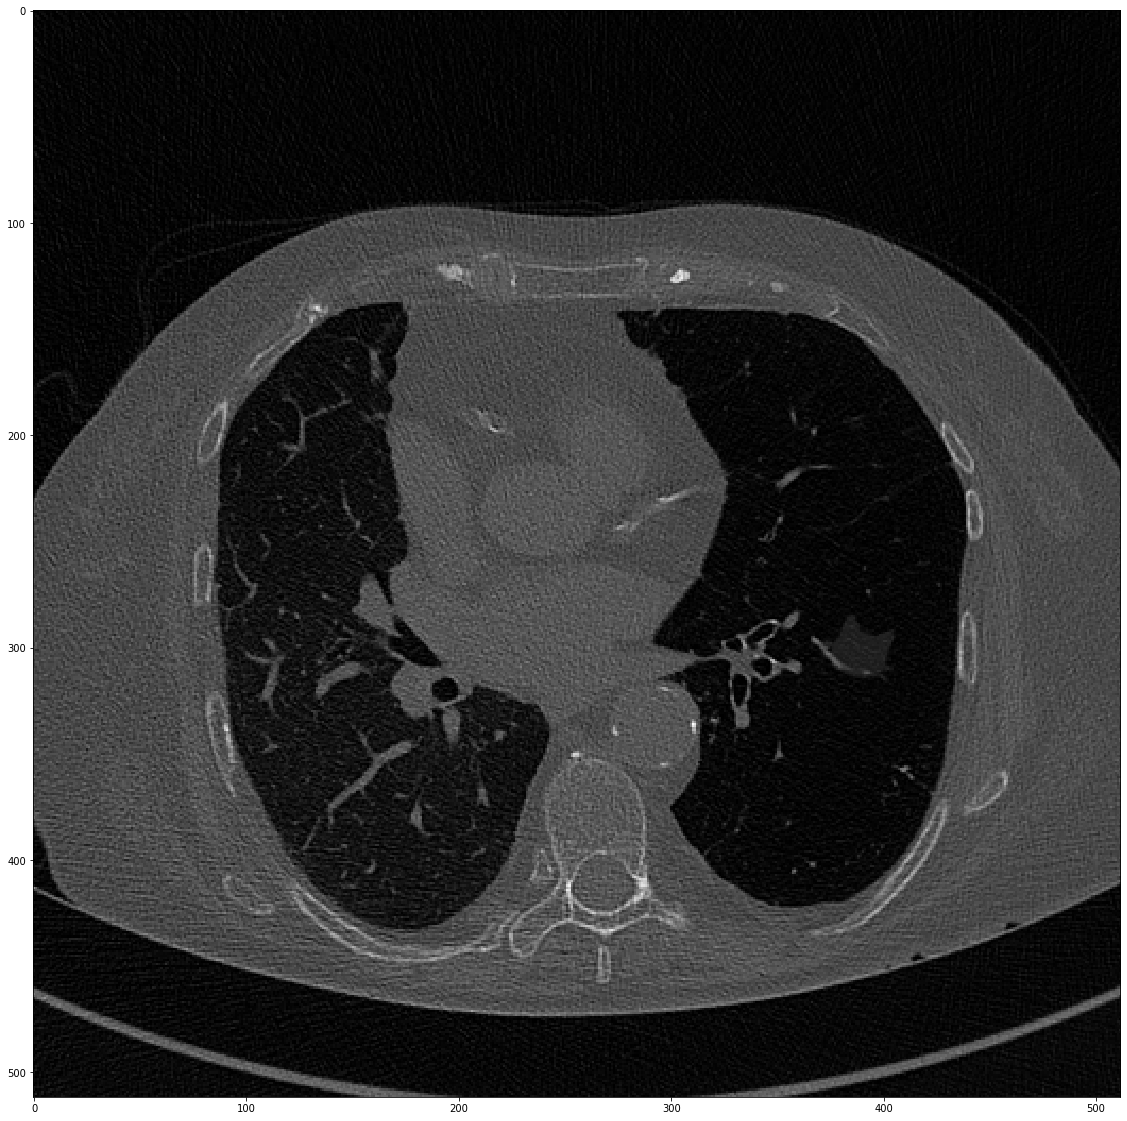

In [68]:
plt.figure(figsize=(20,20))
plt.imshow(catslice)

In [9]:
vol = nd_load_img.resolve(1)
vol = sitk.GetArrayFromImage(vol)
msk = nd_lungmask.resolve(1)
centersl_img, centersl_msk = nd_centerslice.resolve(1)

Compute:  get_vol  Item:  1 Domain:  default
INFO:CirData.Base:Request volume from event: 29522EA0_20101128_dicom_8439 
Reload from persistent:  apply  Item:  1 Domain:  default   3cd5fb7daf0b2b7191a19ee428e11686c47ed2ca
Reload from persistent:  centerslice  Item:  1 Domain:  default   261fdf801a07a79c15887bab119891aaa2451e90


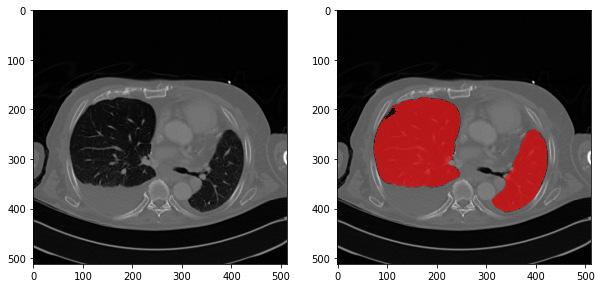

In [10]:
mut.mimshow(centersl_img, centersl_msk)

In [ ]:
pydicom.

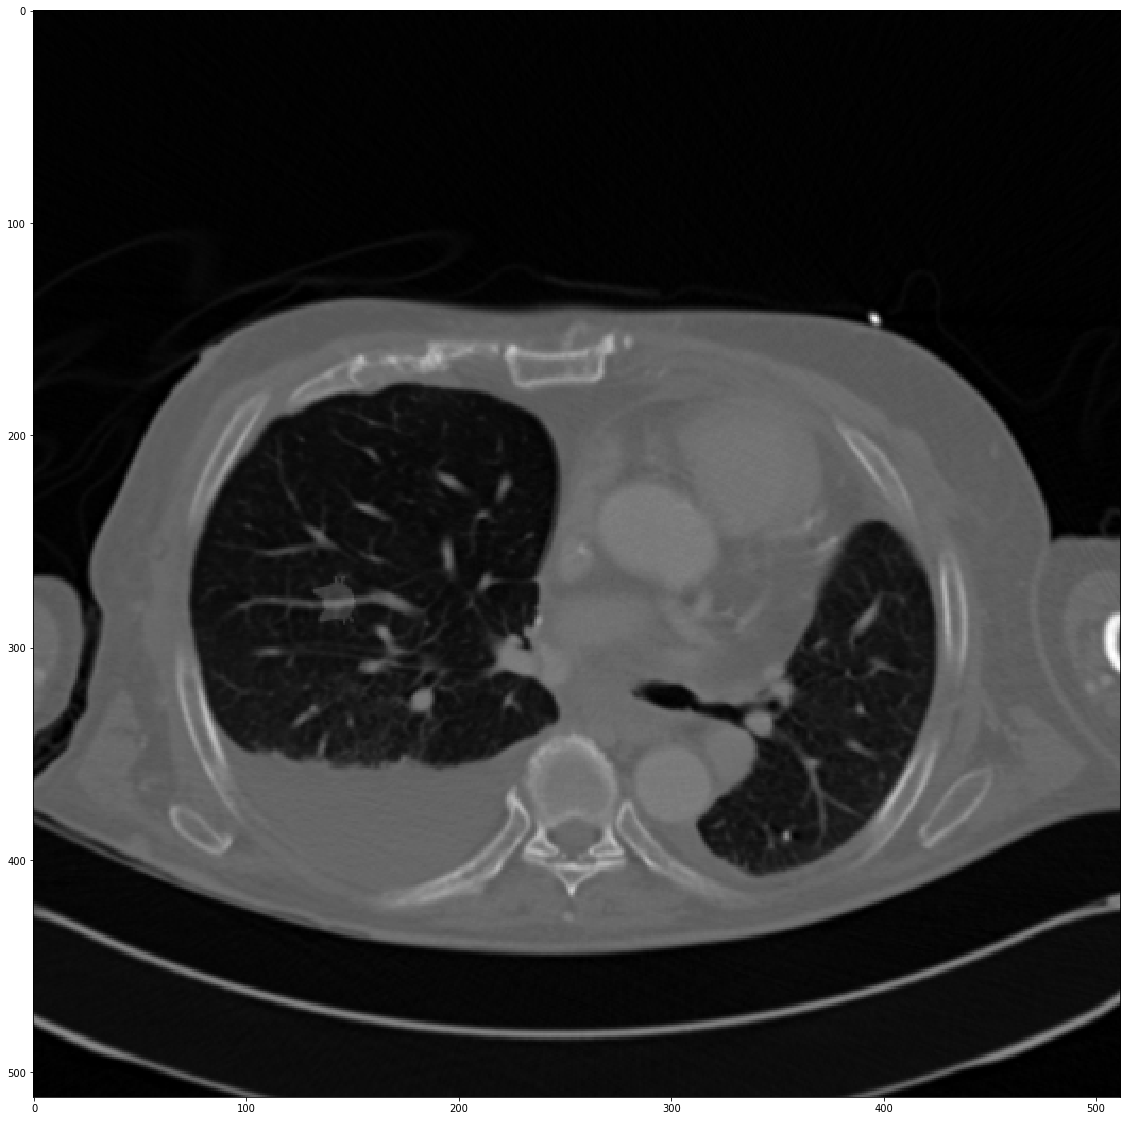

In [490]:
msk = msk>0

cat = np.load('/home/jhofmanninger/Projects/siim/catpic.npy')
cat_rs = mut.rescale(cat,random.uniform(0.4,0.8),order=1, anti_aliasing=True)
cat_rot = rotate(cat_rs, random.uniform(0,359), order=1)
cat_rot = mut.crop_to_mask(cat_rot,msk=cat_rot>0)
cat_size = cat_rot.shape
cat_rot_dist = np.sqrt(cat_rot.shape[0]**2+cat_rot.shape[1]**2)

centersli = int(np.round(np.mean(np.where(np.sum(np.sum(msk,axis=1),axis=1)))))
centersl_msk = msk[centersli, ...]
centersl_img = vol[centersli, ...]
sl_dt = edt.edt(centersl_msk)

sl_dt = sl_dt>(cat_rot_dist/2)
rc = np.asarray(np.where(sl_dt))[:,np.random.randint(np.sum(sl_dt.astype(int)))]

catcut = centersl_img[rc[0]-np.floor(cat_size[0]/2).astype(int):rc[0]+np.ceil(cat_size[0]/2).astype(int),
                      rc[1]-np.floor(cat_size[1]/2).astype(int):rc[1]+np.ceil(cat_size[1]/2).astype(int)]
catcut_withcat = catcut+(cat_rot/255)*random.uniform(300,500)


centersl_img_withcat = centersl_img.copy()
centersl_img_withcat[rc[0]-np.floor(cat_size[0]/2).astype(int):rc[0]+np.ceil(cat_size[0]/2).astype(int),
                      rc[1]-np.floor(cat_size[1]/2).astype(int):rc[1]+np.ceil(cat_size[1]/2).astype(int)] = catcut_withcat

plt.figure(figsize=(20,20))
plt.imshow(centersl_img_withcat)

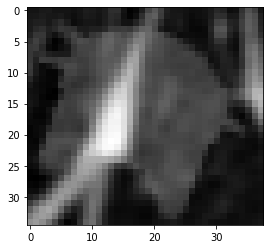

In [381]:
plt.imshow(catcut_withcat)

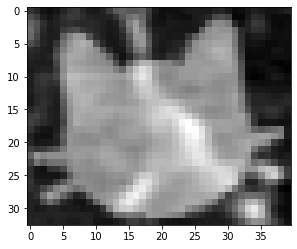

In [332]:
catcut.shape

(33, 40)

In [ ]:
mut.rescale()

In [80]:
sl_dt.max()

63.28507

In [105]:
random.uniform(0.4,0.8)

0.575521071890748

In [91]:
np.sqrt(30**2+35**2)

46.09772228646444

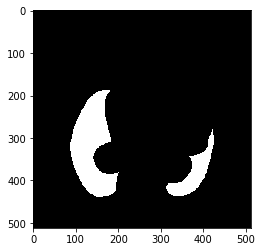

In [92]:
plt.imshow(sl_dt>np.sqrt(30**2+35**2)/2)

34.655446902326915


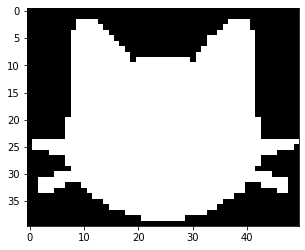

In [301]:

print(cat_rot_dist)
plt.imshow(cat)

In [108]:
?? augmentation

Type:        module
String form: <module 'py_jotools.augmentation' from '/home/jhofmanninger/Projects/py_jotools/py_jotools/augmentation.py'>
File:        ~/Projects/py_jotools/py_jotools/augmentation.py
Source:     
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import rotate
from scipy.ndimage.interpolation import map_coordinates
import random


def elastic_deformation_2d(image, label=None, cval = 0, alpha=1.2, sigma=0.09, mode = 'constant', order=2):
    indices = _elastic_transform(image.shape[0:2], alpha=image.shape[1]*alpha, sigma=image.shape[1]*sigma)
    deformed = map_coordinates(image, indices, order=order, mode=mode, prefilter=True).reshape(image.shape)
    deformed_label = []
    if not label is None:
        deformed_label = map_coordinates(label, indices, order=0, cval=cval).reshape(label.shape)

    return deformed, deformed_label


def rotation_2d(image, label=None, cval=0.0, degrees=15,  mode = 'constant', label_is_image=False, 

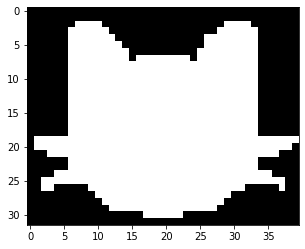

In [89]:
plt.imshow(mut.rescale(cat,random.uniform(0.4,0.8),order=0))

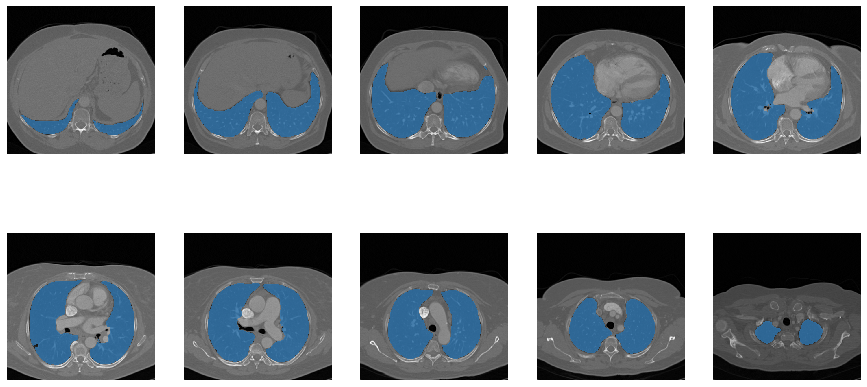

In [53]:
mut.mimshow(vol,msk)

In [95]:
model = resunet.UNet(n_classes=3, padding=True,  depth=5, up_mode='upsample', batch_norm=True, residual=False)
model.load_state_dict(torch.load('/project/candid/DATA/LUNET/models_aug/unet_full_ard_fib_novis/model_ep10'))
model.eval();

In [27]:
test_vol = cd.get_vol_event('0759FACL_20150303_dicom_253716')

INFO:CirData.Base:Request volume from event: 0759FACL_20150303_dicom_253716 


In [28]:
# inimg_raw = sitk.GetArrayFromImage(test_vol)
# inimg_raw = scipy.ndimage.gaussian_filter(inimg_raw,[0, 0.65, 0.65],0)
# inimg_raw = sitk.GetImageFromArray(inimg_raw)
# inimg_raw.CopyInformation(test_vol)
# msk = lungmask.apply(inimg_raw, lungmask.get_model('unet','R231'),volume_postprocessing=True)

In [33]:
msk = lungmask.apply(test_vol, lungmask.get_model('unet','LTRCLobes'), volume_postprocessing=False)
#  msk = lungmask.apply(test_vol,model,volume_postprocessing=True)

100%|██████████| 22/22 [00:04<00:00,  4.41it/s]


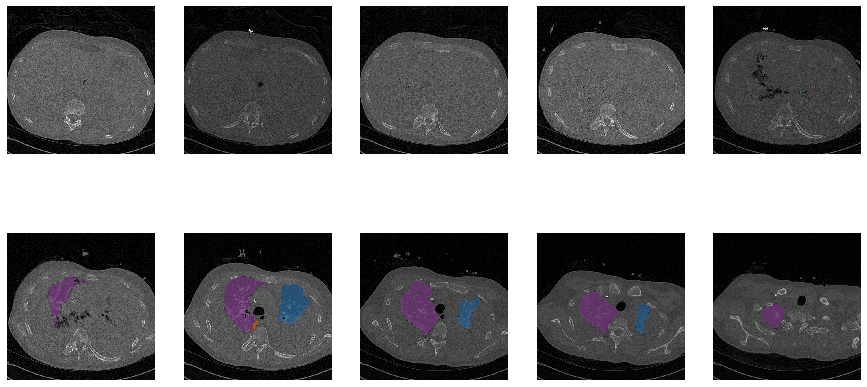

In [34]:
mut.mimshow(test_vol, msk, alpha=0.7)

In [66]:
iname = '01SBW0BY_20111115_dicom_257560'
sitk.WriteImage(test_vol,'/project/candid/DATA/LUNET/volumes_after_paper/' + iname + '.nii.gz')
msk_out = sitk.GetImageFromArray(msk)
msk_out.CopyInformation(test_vol)
sitk.WriteImage(msk_out,'/project/candid/DATA/LUNET/masks_after_paper/' + iname + '.nii.gz')

In [111]:
?? lungmask

Type:        module
String form: <module 'lungmask.lungmask' from '/home/jhofmanninger/Projects/LUNET_deploy/deploy/lungmask/lungmask/lungmask.py'>
File:        ~/Projects/LUNET_deploy/deploy/lungmask/lungmask/lungmask.py
Source:     
import numpy as np
import torch
from . import utils
import SimpleITK as sitk
import skimage
from .resunet import UNet
import scipy.ndimage as ndimage
import warnings
import sys
from tqdm import tqdm

import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
warnings.filterwarnings("ignore",category=UserWarning)

# stores urls and number of classes of the models
model_urls = {('unet','R231'): ('http://www.cir.meduniwien.ac.at/downloads/unet_r231-d5d2fc3d.pth',3),
('unet','LTRCLobes'): ('http://www.cir.meduniwien.ac.at/downloads/unet_ltrclobes-3a07043d.pth',6)}


def apply(image, model, force_cpu=False, batch_size=20, volume_postprocessing=True, show_process=True):

    voxvol = np.prod(image.GetSpacing())
    inimg_raw = sitk.GetArrayFromIm